In [ ]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [ ]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [ ]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [ ]:
def OMP(s, D, L, tau):
  N = D.shape[1]
  x = np.zeros(N)
  r = s
  omega = []
  while np.count_nonzero(x) < L and np.linalg.norm(r) > tau:
      e = np.zeros(N)
      for j in range(N):
          e[j] = np.linalg.norm(r)**2 - ((r.T @ D[:, j])  / np.linalg.norm(D[:, j]))**2
      jStar = np.argmin(e)
      omega = np.append(omega, jStar).astype(int)
      x_omega =  np.linalg.inv(D[:, omega].T @ D[:, omega]) @ D[:, omega].T @ s
      x = np.zeros(N)
      x[omega] = x_omega
      r = s - D @ x
  return x

Load the image and rescale it in $[0,1]$

In [ ]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image

In [ ]:
npatch = 10000

S = np.zeros((M, npatch))
for i in range(npatch):
    x = np.random.randint(0, imsz[0] - p)
    y = np.random.randint(0, imsz[1] - p)
    S[:, i] = img[x: x + p, y: y + p].reshape(-1, order='F')


Remove the mean from the patches (each column of $S$ must have zero-mean)

In [ ]:
S = S - np.mean(S, axis=0)


Initialize the dictionary and the coefficient matrix

In [ ]:
# number of columns of the dictionary
N = 256

# intialize the dictionary with N random columns from S
D = np.random.randn(M, N)

# normalize each column of D (zero mean and unit norm)
# UPDATE D
for i in range(N):
    D[:, i] = D[:, i] - np.mean(D[:, i])
    D[:, i] = D[:, i] / np.linalg.norm(D[:, i])

# number of iteration of the KSVD
max_iter = 5

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))


Main KSVD loop


In [ ]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:, n], D, L, 0)

    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.where(X[j, :] != 0)[0]

        if len(omega) == 0:
            # if the atom is never used then ignore or substitute it with a random vector
            pass
        else:
            # compute the residual matrix E, ignoring the j-th atom
            E = S - D @ X + D[:, [j]] @ X[[j], :]

            # restrict E to the columns indicated by omega
            Eomega = E[:, omega]

            # compute the SVD of Eomega
            U, Sigma, V_T = np.linalg.svd(Eomega)
            #SIG = np.zeros((U.shape[0], V.shape[0]))
            #SIG[:Sigma.shape[0], :Sigma.shape[0]] = np.diag(Sigma)
            # update the dictionary
            D[:,j] = U[:,0]

            # update the coefficient matrix
            X[j,omega]= Sigma[0] * V_T[0,:]

    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
558
iter 1
636
iter 2
566
iter 3
570
iter 4
577


Show the learned dictionary

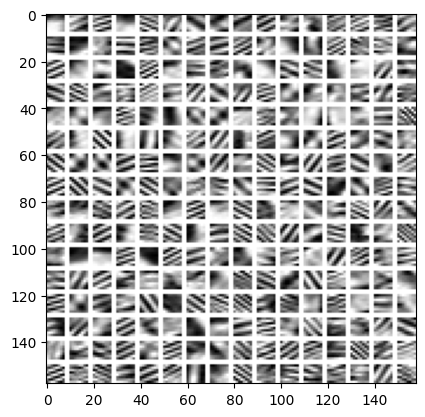

In [ ]:
img_dict = get_dictionary_img(D)
plt.figure(figsize=(10, 10))
plt.imshow(img_dict, cmap='gray')
